## Create water mask in radar coordinate ##

This notebook shows two ways of generating water mask in radar coordinates to facilitate InSAR processing in MintPy:

1. Using `wbd.py` from ISCE to download water mask in geo coordinates and radar-code it using `geocode.py` from MintPy.
2. Using `generate_mask.py` based on DEM in radar coordiantes with `manually` selected threshold in height.

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
from mintpy.cli import view

## Option 1: Download water mask using `wbd.py` from ISCE and radar-code it

Go to directory /Users/yunjunz/data/test/FernandinaSenDT128/merged/geom_reference
view.py /Users/yunjunz/data/aux/DEM/swbdLat_S01_N00_Lon_W092_W091.wbd -c gray --noverbose


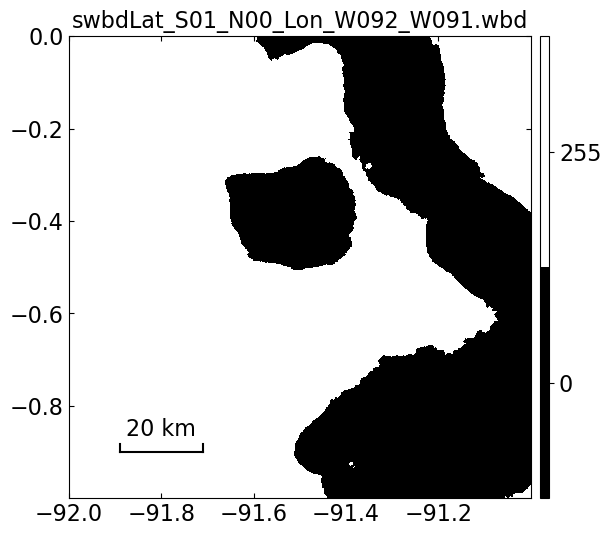

number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: lat.rdr
input pixel size in (lat, lon) in degree: [-0.0002777777777777778, 0.0002777777777777778]
input area extent in (S, N, W, E) in degree: (-0.9998611111111111, 0.0001388888888888889, -92.00013888888888, -91.00013888888888)
--------------------------------------------------
resampling file: /Users/yunjunz/data/aux/DEM/swbdLat_S01_N00_Lon_W092_W091.wbd
--------------------------------------------------1/1
reading band1 in block (0, 0, 3600, 3600) from swbdLat_S01_N00_Lon_W092_W091.wbd ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 1 segments ...
write file: waterBody.rdr
write file: waterBody.rdr.rsc
write file: waterBody.rdr.xml
write file: waterBody.rdr.vrt
time used: 00 mins 1.3 secs.

view.py waterBody.rdr -c gray --flip-lr --noverbose


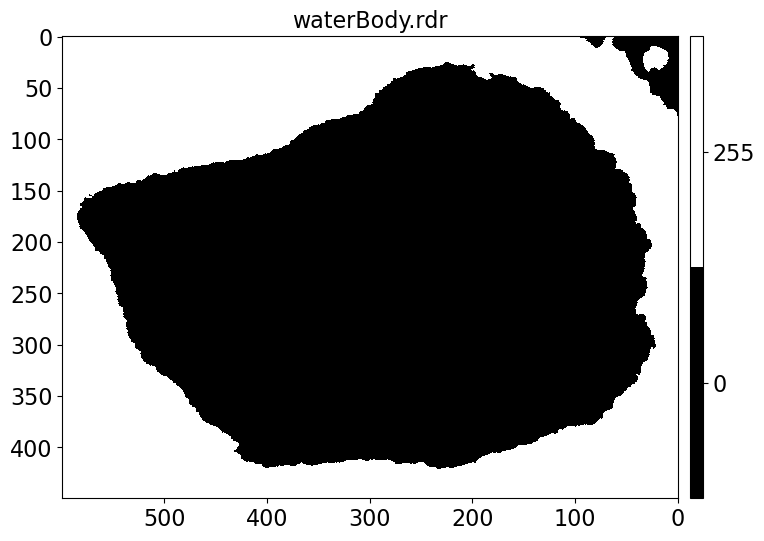

input .wbd file: waterBody.rdr
read waterBody.rdr
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value > 0.5
write file: waterMask.rdr
write file: waterMask.rdr.rsc
time used: 00 mins 0.0 secs.
view.py waterMask.rdr -c gray --flip-lr --noverbose


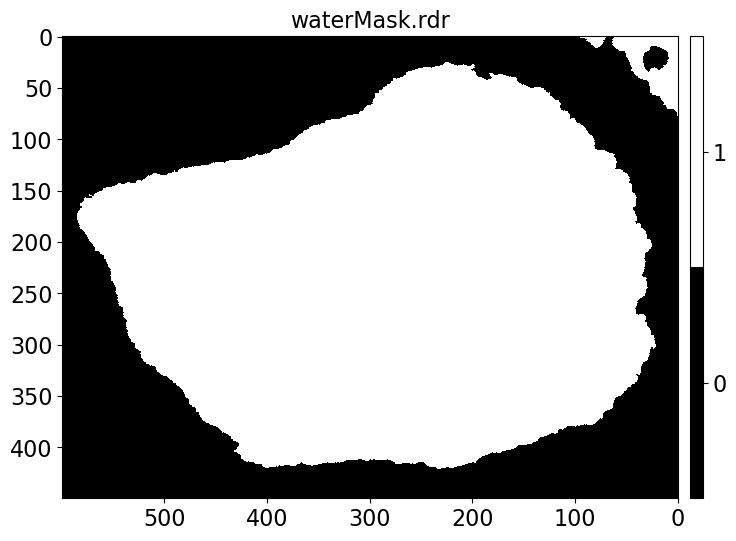

In [2]:
work_dir = os.path.expanduser('~/data/test/FernandinaSenDT128/merged/geom_reference')
os.chdir(work_dir)
print('Go to directory', work_dir)

# 1. Downloads water body mask from USGS using wbd.py
# This will create file swbdLat_S01_N00_Lon_W092_W091.wbd in the current directory, or in $DEMDB if it's defined.
# The file contains 255 for water and 0 for land
!wbd.py -1 0 -92 -91   #S N W E in degrees
wbd_file = os.path.expandvars('${DEMDB}/swbdLat_S01_N00_Lon_W092_W091.wbd')
view.main(f'{wbd_file} -c gray --noverbose'.split())

# 2. Convert to radar coordinates
# This will radar-code the downloaded swbdLat_S01_N00_Lon_W092_W091.wbd into waterBody.h5 file.
# The no-data pixels will be filled with value of 255 (as water body)
!geocode.py $wbd_file -o waterBody.rdr --lat-file lat.rdr --lon-file lon.rdr --geo2radar --fill 255
view.main('waterBody.rdr -c gray --flip-lr --noverbose'.split())

# 3. Adjust value for MintPy: 0 for water and 1 for land
# This will generate waterMask.h5 from waterBody.h5 file.
!generate_mask.py waterBody.rdr --max 0.5 -o waterMask.rdr
view.main('waterMask.rdr -c gray --flip-lr --noverbose'.split())

## Option 2: Thresholding DEM in radar coordinates using `generate_mask.py`

Go to directory /Users/yunjunz/data/test/FernandinaSenDT128/mintpy
view.py ./inputs/geometryRadar.h5 height --noverbose


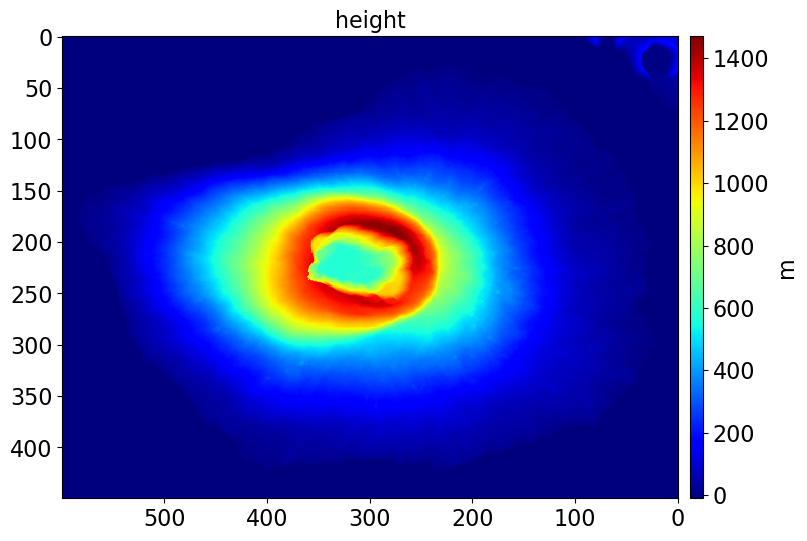

input geometry file: INPUTS/geometryRadar.h5
read INPUTS/geometryRadar.h5 height
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < -5.5
delete exsited file: waterMask.h5
create HDF5 file: waterMask.h5 with w mode
create dataset /mask of bool       in size of (450, 600)           with compression=None
finished writing to waterMask.h5
time used: 00 mins 0.0 secs.
view.py waterMask.h5 -c gray --noverbose


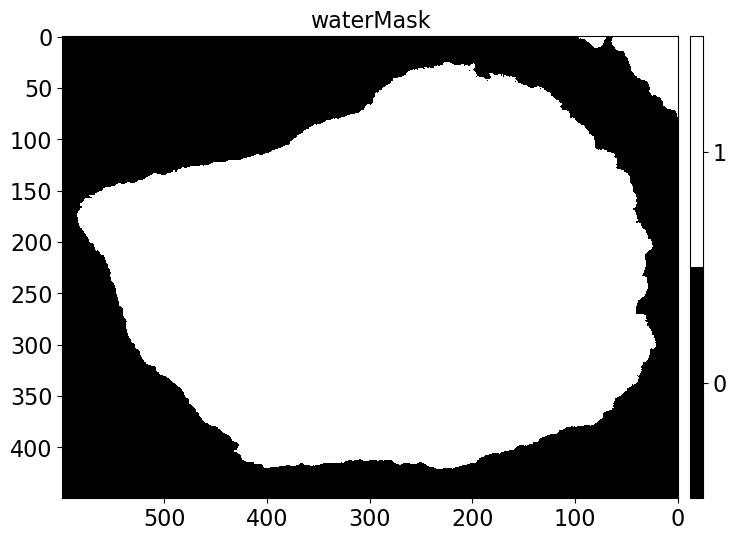

In [3]:
work_dir = os.path.expanduser('~/data/test/FernandinaSenDT128/mintpy')
os.chdir(work_dir)
print('Go to directory', work_dir)

# 1. run view.py to plot the height
# Hover around to see the maximum height on the water (shown in the status bar)
# because height on the water varies in the DEM file with respect to the ellipsoid (*.wgs84 file in ISCE)
view.main('./inputs/geometryRadar.h5 height --noverbose'.split())
# Let's say here the maximum height value on the water you found is -6 m

# 2. run generate_mask.py to create a mask based on the threshold
!generate_mask.py INPUTS/geometryRadar.h5 height -m -5.5 -o waterMask.h5
view.main('waterMask.h5 -c gray --noverbose'.split())